In [1]:
import os
import time
import urllib

import cv2
import numpy as np
import torch

from IPython.display import clear_output, display
from PIL import Image
from lang_sam import SAM_MODELS
from lang_sam.models.gdino import GDINO

from sam2.build_sam import build_sam2_object_tracker
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto
torch_dtype=torch.float16

tokenizer model Qwen, Llama 중 선택이 가능합니다.   
이 외에도 huggingface에서 모델 불러오기가 가능합니다.

In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [3]:
class Visualizer:
    def __init__(self,
                 video_width,
                 video_height,
                 ):
        
        self.video_width = video_width
        self.video_height = video_height

    def resize_mask(self, mask):
        mask = torch.tensor(mask, device='cpu')
        mask = torch.nn.functional.interpolate(mask,
                                               size=(self.video_height, self.video_width),
                                               mode="bilinear",
                                               align_corners=False,
                                               )
        
        return mask

    def add_frame(self, frame, mask):
        frame = frame.copy()
        frame = cv2.resize(frame, (self.video_width, self.video_height))
        
        mask = self.resize_mask(mask=mask)
        mask = (mask > 0.0).numpy()
        
        for i in range(mask.shape[0]):
            obj_mask = mask[i, 0, :, :]
            frame[obj_mask] = [255, 105, 180]
                
        rgb_frame = Image.fromarray(frame)
        clear_output(wait=True)
        display(rgb_frame)

In [4]:
# Set SAM2 Configuration
# NUM_OBJECTS = 2
NUM_OBJECTS = 1
# SAM_CHECKPOINT_FILEPATH = "./checkpoints/sam2.1_hiera_base_plus.pt"
# SAM_CONFIG_FILEPATH = "./configs/samurai/sam2.1_hiera_b+.yaml"
SAM_CHECKPOINT_FILEPATH = "./checkpoints/sam2.1_hiera_tiny.pt"
SAM_CONFIG_FILEPATH = "./configs/samurai/sam2.1_hiera_t.yaml"
# SAM_CONFIG_FILEPATH = "./configs/sam2.1/sam2.1_hiera_t.yaml"
DEVICE = 'cuda:0'

In [5]:
# Open Video Stream
# video_stream = cv2.VideoCapture(VIDEO_STREAM)
video_stream = cv2.VideoCapture(0)

video_height = int(video_stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video_stream.get(cv2.CAP_PROP_FRAME_WIDTH))

# For real-time visualization
visualizer = Visualizer(video_width=video_width,
                        video_height=video_height
                        )

sam = build_sam2_object_tracker(num_objects=NUM_OBJECTS,
                                config_file=SAM_CONFIG_FILEPATH,
                                ckpt_path=SAM_CHECKPOINT_FILEPATH,
                                device=DEVICE,
                                verbose=False
                                )
gdino = GDINO()
gdino.build_model()

In [6]:
def get_bbox(images_pil, texts_prompt, box_threshold, text_threshold):
    gdino_results = gdino.predict(images_pil, texts_prompt, box_threshold, text_threshold)
    sam_boxes = []
    sam_indices = []
    for idx, result in enumerate(gdino_results):
        result = {k: (v.cpu().numpy() if hasattr(v, "numpy") else v) for k, v in result.items()}
        processed_result = {
            **result,
            "masks": [],
            "mask_scores": [],
        }

        sam_boxes.append(processed_result["boxes"])
        sam_indices.append(idx)

    return sam_boxes
    

In [7]:
def get_response(tokenizer, model, query):
    prompt = "Extract the object from the query or determine the tool that meets the query's intent, ending with a period.\
        Example 1: Query: pick a tool for communicate. Object: iphone.\
        Example 2: Query: I am tired. Object: chair.\
        Provide the response as a word of the object's value as a string, with no additional text.\
        Example response: 'iphone.'"
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
        {"role": "user", "content": query}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    generated_ids = model.generate(
        model_inputs.input_ids,
        attention_mask=model_inputs.attention_mask,
        max_new_tokens=512,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

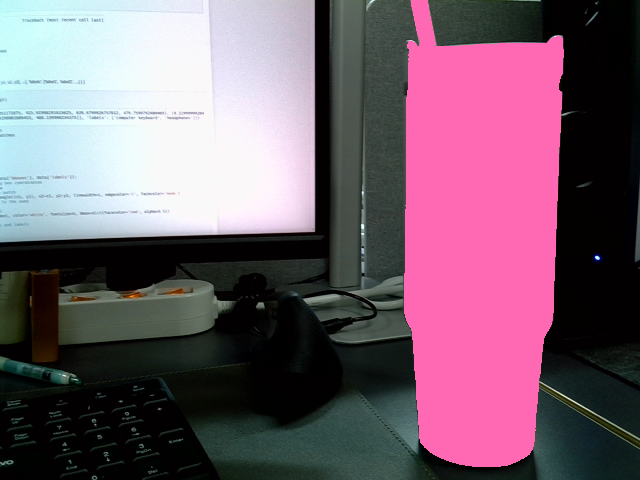

KeyboardInterrupt: 

In [8]:
# 아래는 query의 예시입니다.
# query = "I am dehydrated"
# query = "I am thirsty"
# query = "I want to read"
# query = "I am bored"
# query = "I need a tool for writing"
# query = "I have to write something down"
# query = "I have to call him"

available_slots = np.inf
count = 1
total = 0
li = []
# text_prompt = ["water bottle."]
text_prompt = [get_response(tokenizer, model, query=input("What are you looking for? "))]

first_frame = True
with torch.inference_mode(), torch.autocast('cuda:0', dtype=torch.bfloat16):
    while video_stream.isOpened():
        # Get next frame
        ret, frame = video_stream.read()
        # Exit if no frames remaining
        if not ret:
            break

        # Convert frame from BGR to RGB
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ftime = time.time()
        # Simulate detection on first frame
        if first_frame:
            image = Image.fromarray(img)
            bbox = get_bbox([image], text_prompt, 0.3, 0.25)
            xyxy = bbox[0][0]
            bbox = [[xyxy[0], xyxy[1]], [xyxy[2], xyxy[3]]]
            bbox = np.array(bbox, dtype=np.float32)
            sam_out = sam.track_new_object(img=img,
                                           box=bbox
                                           )
            
            first_frame = False
            
        else:
            sam_out = sam.track_all_objects(img=img)
            
        visualizer.add_frame(frame=img, mask=sam_out['pred_masks'])
        ntime = time.time()
        delayed_time = (ntime - ftime) * 1000
        FPS = int(1./(ntime - ftime ))
        total += delayed_time
        if count % 10 == 0:
            li.append(f"{count}: FPS {FPS} / avg {total/count}")
        count += 1
    

FPS, 지연시간 측정용   
n번째 프레임에서의 FPS와 평균 지연 시간을 표시

In [9]:
video_stream.release()
print(li)

['10: FPS 11 / avg 108.93445014953613', '20: FPS 10 / avg 97.48287200927734', '30: FPS 10 / avg 96.94274266560872', '40: FPS 10 / avg 95.45050859451294', '50: FPS 10 / avg 95.11842727661133', '60: FPS 10 / avg 94.91253693898518', '70: FPS 10 / avg 94.58084447043282', '80: FPS 10 / avg 94.2740797996521', '90: FPS 10 / avg 94.2785660425822', '100: FPS 10 / avg 94.05244827270508', '110: FPS 10 / avg 93.88648813421077', '120: FPS 10 / avg 93.87506047884624', '130: FPS 11 / avg 93.5224753159743', '140: FPS 10 / avg 93.36181368146624', '150: FPS 10 / avg 93.25743834177653', '160: FPS 10 / avg 93.17653179168701', '170: FPS 10 / avg 93.1908369064331', '180: FPS 11 / avg 93.02040206061469', '190: FPS 10 / avg 92.93482178135922', '200: FPS 10 / avg 92.88629412651062', '210: FPS 10 / avg 92.80814216250465', '220: FPS 11 / avg 92.74431033567949', '230: FPS 11 / avg 92.69563633462657', '240: FPS 10 / avg 92.6449179649353', '250: FPS 10 / avg 92.58509540557861', '260: FPS 11 / avg 92.55290581629826'